Alasan | Bernados | Macalam | Gaca | Tion | Torillo
# Tobacco Reports
**Adverse event reports related to tobacco products**

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [65]:
url = 'https://raw.githubusercontent.com/RenzWoo/ALASAN/refs/heads/main/DATA%20MINING/tobacco-problem-0001-of-0001.json'
response = requests.get(url)
data = response.json()

In [66]:
df = pd.DataFrame(data['results'])[:1000]
df.head()

,date_submitted,nonuser_affected,reported_health_problems,number_tobacco_products,report_id,number_health_problems,reported_product_problems,tobacco_products,number_product_problems
0,08/09/2019,No,"[Lip injury, Mouth injury, Nose injury, Bleedi...",1,944,9,[No information provided],"[Electronic cigarette, electronic nicotine or ...",0
1,08/09/2019,No,"[Tonic-clonic seizures, Seizure cluster]",1,1199,2,[No information provided],"[Electronic cigarette, electronic nicotine or ...",0
2,08/08/2019,No,[Seizure],1,923,1,[No information provided],"[Electronic cigarette, electronic nicotine or ...",0
3,07/25/2019,Yes,"[Diarrhea, Burning eyes, Chest cold, Daydreami...",1,908,11,[No information provided],"[Electronic cigarette, electronic nicotine or ...",0
4,01/22/2017,No,[Chemical burn],1,247,1,"[Exploded, caught on fire, or burned abnormally]","[Electronic cigarette, electronic nicotine or ...",1


**Raw summary**

In [67]:
df.describe()

,number_tobacco_products,report_id,number_health_problems,number_product_problems
count,1000.000000,1.000000e+03,1000.00000,1000.000000
mean,1.043000,9.562482e+05,1.88200,0.899000
std,0.281479,1.050673e+06,2.54923,1.713399
min,1.000000,2.250000e+02,0.00000,0.000000
25%,1.000000,7.807500e+02,1.00000,0.000000
50%,1.000000,1.185500e+03,1.00000,0.000000
75%,1.000000,2.089348e+06,2.00000,1.000000
max,5.000000,2.179397e+06,40.00000,22.000000


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date_submitted             1000 non-null   object
 1   nonuser_affected           1000 non-null   object
 2   reported_health_problems   1000 non-null   object
 3   number_tobacco_products    1000 non-null   int64 
 4   report_id                  1000 non-null   int64 
 5   number_health_problems     1000 non-null   int64 
 6   reported_product_problems  1000 non-null   object
 7   tobacco_products           1000 non-null   object
 8   number_product_problems    1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [69]:
df.isna().sum()

,0
date_submitted,0
nonuser_affected,0
reported_health_problems,0
number_tobacco_products,0
report_id,0
number_health_problems,0
reported_product_problems,0
tobacco_products,0
number_product_problems,0


# Checking unique values from categorical data

In [70]:
affected = set(i for i in df['nonuser_affected'])
affected

{'Neither', 'No', 'No information provided', 'Unknown', 'Yes'}

In [71]:
health_problems = set(j for i in df['reported_health_problems'] for j in i)
print("Number of Unique values: ", len(health_problems))
#print(health_problems)

Number of Unique values:  833


In [72]:
product_problems = set(j for i in df['reported_product_problems'] for j in i)
print("Number of Unique values: ", len(product_problems))
#print(product_problems)

Number of Unique values:  33


In [73]:
tobacco_products = set(j for i in df['tobacco_products'] for j in i)
print("Number of Unique values: ", len(tobacco_products))
#print(tobacco_products)

Number of Unique values:  26


# Type casting & Missing value handling

In [74]:
df['date_submitted'] = pd.to_datetime(df['date_submitted'])

In [75]:
df['nonuser_affected'] = df['nonuser_affected'].apply(lambda x: None if x == 'No information provided' else x)

In [76]:
df['reported_health_problems'] = df['reported_health_problems'].apply(lambda x: None if x == ['No information provided'] else x)

In [77]:
df['reported_product_problems'] = df['reported_product_problems'].apply(lambda x: None if x == ['No information provided'] else x)

In [78]:
df.isna().sum()

,0
date_submitted,0
nonuser_affected,99
reported_health_problems,181
number_tobacco_products,0
report_id,0
number_health_problems,0
reported_product_problems,588
tobacco_products,0
number_product_problems,0


The raw values in columns like reported_health_problems, reported_product_problems, and tobacco_products are often inconsistent, unstructured, or contain multiple issues grouped together. By cleaning the text, we remove irregularities such as missing values or placeholder entries (e.g., “No information provided”).

# Text Cleaning & Feature Engineering

Normalization makes sure similar issues written in different ways are treated the same, turning messy text into structured features that can be counted, encoded, and analyzed effectively.

In [79]:
def categorize_data(instance, common_words):
    for category, keywords in common_words.items():
        if any(kw in instance.lower() for kw in keywords):
            return category
    return "other"

## Reported health problems [List of strings]

In [80]:
# mapping
key_health_problems = {
    "respiratory_problem": ["cough", "lung", "breath", "pneumonia", "respiratory", "asthma", "dyspnea"],
    "neurological_problem": ["seizure", "headache", "migraine", "epilepsy", "convulsion", "tremor", "memory"],
    "cardiac_problem": ["chest", "heart", "tachycardia", "hypertension", "arrhythmia", "stroke"],
    "psychiatric_problem": ["anxiety", "depression", "hallucination", "behavior", "mood", "suicid"],
    "skin_burn_problem": ["burn", "lesion", "rash", "blister", "eczema"],
    "digestive_problem": ["abdominal", "vomit", "diarrhea", "stomach", "pancreatitis"],
    "general_problem": ["injury", "pain", "fatigue", "infection", "illness", "hospital"],
    "other": ["other"]
}

df["reported_health_problems"] = df["reported_health_problems"].apply(
    lambda issues: {categorize_data(i, key_health_problems) for i in issues} if isinstance(issues, list) else set()
)

## Reported product problems [List of strings]

In [81]:
# mapping
key_product_problems = {
    "fire_explosion": ["exploded", "fire", "burned", "overheated"],
    "damage": ["damaged", "broken", "defective"],
    "smell_taste": ["smell", "taste", "appearance"],
    "label_instruction": ["label", "instruction"],
    "safety": ["child safety"],
    "quantity": ["wrong number", "wrong product", "leaked", "spilled"],
    "hard_to_use": ["hard to open", "hard to use"],
    "foreign_material": ["foreign material"],
    "other": ["other"]
}

In [82]:
df["reported_product_problems"] = df["reported_product_problems"].apply(
    lambda issues: {categorize_data(i, key_product_problems) for i in issues} if isinstance(issues, list) else set()
)

## Tobacco products [List of strings]

In [83]:
# mapping
key_product_problems = {
    'electronic_cigarette': ['electronic', 'vape', 'e-', 'pen'],
    'cigarette': ['cigarette', 'cigar'],
    'other':['other','tobacco-free'],
    'tobacco':['tobacco', 'chewing', 'snuff']
}

In [84]:
df["tobacco_products"] = df["tobacco_products"].apply(
    lambda issues: {categorize_data(i,key_product_problems) for i in issues} if isinstance(issues, list) else set()
)

In [85]:
df

,date_submitted,nonuser_affected,reported_health_problems,number_tobacco_products,report_id,number_health_problems,reported_product_problems,tobacco_products,number_product_problems
0,2019-08-09,No,"{other, general_problem}",1,944,9,{},{electronic_cigarette},0
1,2019-08-09,No,{neurological_problem},1,1199,2,{},{electronic_cigarette},0
2,2019-08-08,No,{neurological_problem},1,923,1,{},{electronic_cigarette},0
3,2019-07-25,Yes,"{digestive_problem, skin_burn_problem, cardiac...",1,908,11,{},{electronic_cigarette},0
4,2017-01-22,No,{skin_burn_problem},1,247,1,{fire_explosion},{electronic_cigarette},1
...,...,...,...,...,...,...,...,...,...
995,2019-11-06,No,"{cardiac_problem, other, respiratory_problem}",2,2076566,10,{},"{electronic_cigarette, other}",0
996,2017-04-20,None,{},1,321,0,"{foreign_material, label_instruction}",{electronic_cigarette},2
997,2019-11-02,No,{respiratory_problem},1,2076369,1,{},{electronic_cigarette},0
998,2017-04-25,None,{},1,322,0,"{fire_explosion, other}",{electronic_cigarette},2


# Multi-label Binarization

MultiLabelBinarizer (MLB) technique to handle columns where each record can have multiple categories (e.g., several health problems or products). This technique converts the list-like entries into binary indicator columns (one-hot encoding), making it possible to represent each unique problem or product as a separate feature.

In [86]:
import pandas as pd

def multilabel_encoder(df, column):
    clean_values = df[column].apply(lambda x: x if isinstance(x, set) else ([x] if pd.notna(x) else []))

    unique_labels = sorted({label for sublist in clean_values for label in sublist})

    encoded = pd.DataFrame([[1 if label in row else 0 for label in unique_labels] for row in clean_values],
        columns=unique_labels)

    df_encoded = pd.concat([df[["report_id"]].reset_index(drop=True), encoded], axis=1)
    return df_encoded

## Non_affected_df

In [87]:
non_affected_df = multilabel_encoder(df, 'nonuser_affected')
non_affected_df.head()

,report_id,Neither,No,Unknown,Yes
0,944,0,1,0,0
1,1199,0,1,0,0
2,923,0,1,0,0
3,908,0,0,0,1
4,247,0,1,0,0


## Health_problems_df

In [88]:
health_problems_df = multilabel_encoder(df, 'reported_health_problems')
health_problems_df.head()

,report_id,cardiac_problem,digestive_problem,general_problem,neurological_problem,other,psychiatric_problem,respiratory_problem,skin_burn_problem
0,944,0,0,1,0,1,0,0,0
1,1199,0,0,0,1,0,0,0,0
2,923,0,0,0,1,0,0,0,0
3,908,1,1,1,0,1,0,0,1
4,247,0,0,0,0,0,0,0,1


## Product_problems_df

In [89]:
product_problems_df = multilabel_encoder(df, 'reported_product_problems')
product_problems_df.head()

,report_id,damage,fire_explosion,foreign_material,hard_to_use,label_instruction,other,quantity,safety,smell_taste
0,944,0,0,0,0,0,0,0,0,0
1,1199,0,0,0,0,0,0,0,0,0
2,923,0,0,0,0,0,0,0,0,0
3,908,0,0,0,0,0,0,0,0,0
4,247,0,1,0,0,0,0,0,0,0


## Tobacco_products_df

In [90]:
tobacco_products_df = multilabel_encoder(df, 'tobacco_products')
tobacco_products_df.head()

,report_id,cigarette,electronic_cigarette,other,tobacco
0,944,0,1,0,0
1,1199,0,1,0,0
2,923,0,1,0,0
3,908,0,1,0,0
4,247,0,1,0,0


## Transformed_df

In [91]:
trans_df = df.drop([
    'nonuser_affected',
    'reported_health_problems',
    'reported_product_problems',
    'tobacco_products'], axis=1)
trans_df

,date_submitted,number_tobacco_products,report_id,number_health_problems,number_product_problems
0,2019-08-09,1,944,9,0
1,2019-08-09,1,1199,2,0
2,2019-08-08,1,923,1,0
3,2019-07-25,1,908,11,0
4,2017-01-22,1,247,1,1
...,...,...,...,...,...
995,2019-11-06,2,2076566,10,0
996,2017-04-20,1,321,0,2
997,2019-11-02,1,2076369,1,0
998,2017-04-25,1,322,0,2


# DATA CLEANING

###Duplicate removal

In [92]:
df_for_duplicates = df.drop(columns=['reported_health_problems', 'reported_product_problems', 'tobacco_products'])
print("Duplicates:", df_for_duplicates.duplicated().sum())
df = df.drop_duplicates(subset=df_for_duplicates.columns)

Duplicates: 0


###Missing Data

In [93]:
trans_df.isna().sum()

,0
date_submitted,0
number_tobacco_products,0
report_id,0
number_health_problems,0
number_product_problems,0


###Outlier check

In [94]:
# Detect outliers (IQR method) in numerical fields
for col in ["number_health_problems", "number_product_problems"]:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {outliers.shape[0]} outliers detected (using IQR)")

number_health_problems: 153 outliers detected (using IQR)
number_product_problems: 103 outliers detected (using IQR)


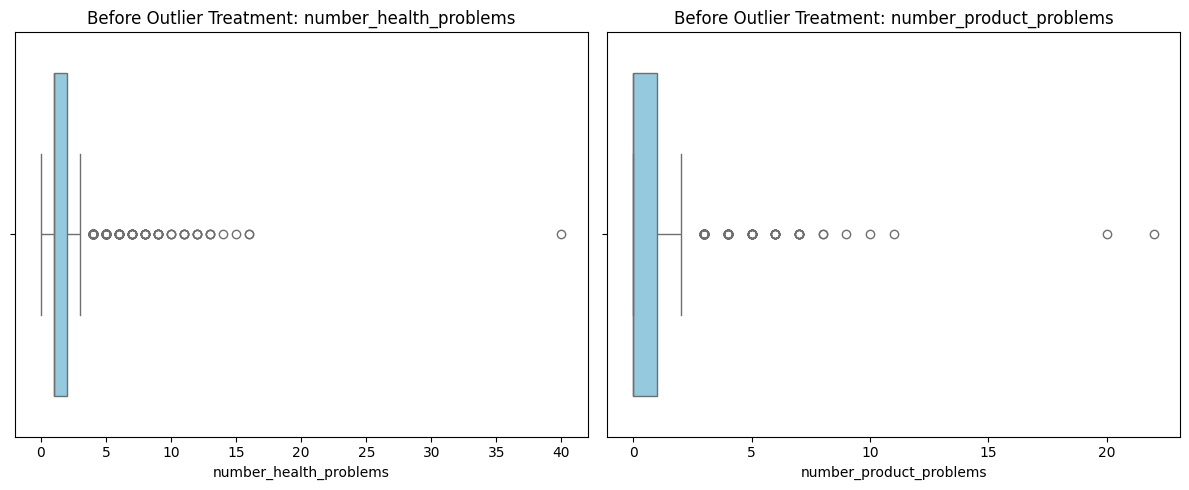

In [95]:
num_cols = ["number_health_problems", "number_product_problems"]

plt.figure(figsize=(12,5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Before Outlier Treatment: {col}")
plt.tight_layout()
plt.show()


###Outlier Treatment

In [96]:
# Winsorize: cap extreme values
for col in ["number_health_problems", "number_product_problems"]:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    df[col] = np.clip(df[col], lower, upper)

print("Cleaned numeric columns with winsorization applied.")

Cleaned numeric columns with winsorization applied.


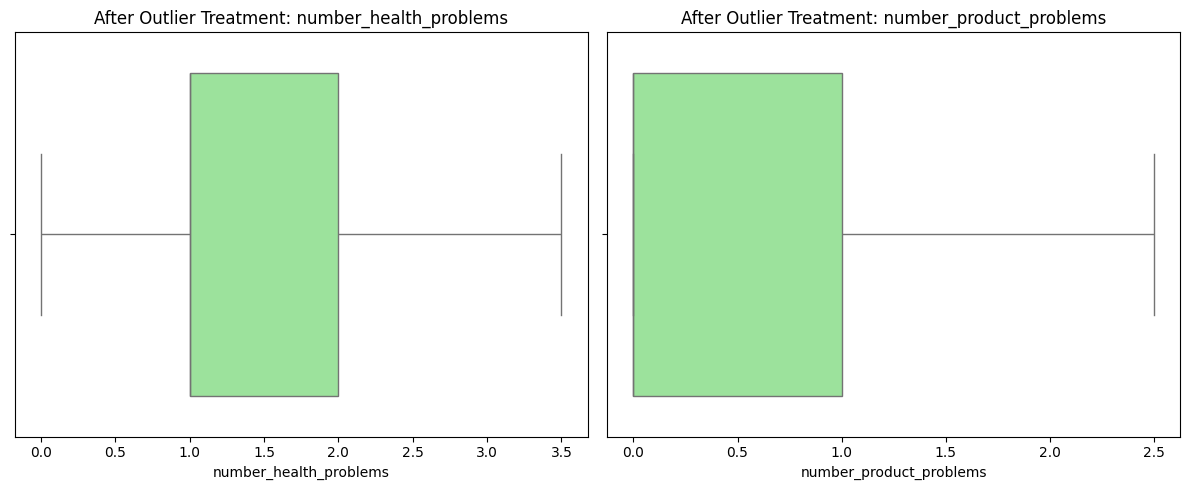

In [97]:
plt.figure(figsize=(12,5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df[col], color="lightgreen")
    plt.title(f"After Outlier Treatment: {col}")
plt.tight_layout()
plt.show()

###Verifying

### Missing values check

In [98]:
trans_df.isna().sum()

,0
date_submitted,0
number_tobacco_products,0
report_id,0
number_health_problems,0
number_product_problems,0
